In [336]:
# install clickhouse library
!pip install clickhouse-driver[lz4]

In [590]:
from clickhouse_driver import Client
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from google.colab import files

In [589]:
# connect to the db
client = Client(host='82.148.25.91',
                user='ro_test',
                password='qwerty',
                database='test')

# EDA

## time

In [374]:
# define time frame for exploration as the first and the last data entries
# considering item's sales
time_start, time_end = client.execute("""SELECT MIN(date), MAX(date) 
                        FROM test.sales where 
                        item_id='7d185936-7a60-11eb-ba7f-4a6a34607ded'""")[0]

print(f'''first sales item entry: {time_start.date()}\n
last sales item entry: {time_end.date()}''')

first sales item entry: 2021-01-04

last sales item entry: 2021-12-30


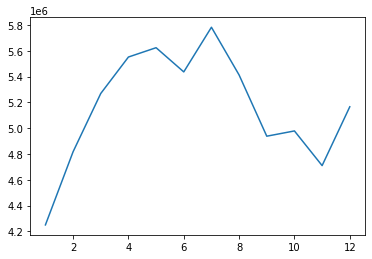

In [375]:
# sales per month
month_stats = client.execute("""SELECT MONTH(date), SUM(quantity) 
                            FROM test.sales WHERE date BETWEEN '2021-01-04' 
                            AND '2021-12-30' GROUP BY MONTH(date)""")

plt.plot(*zip(*month_stats))
plt.show()

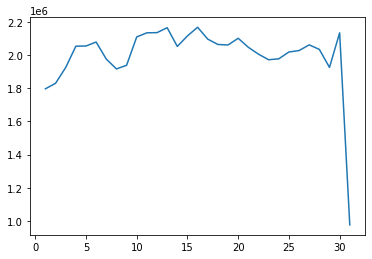

In [376]:
# sales per day of month
month_day_stats = client.execute("""SELECT DAY(date), SUM(quantity) 
                                FROM test.sales WHERE date BETWEEN '2021-01-04' 
                                AND '2021-12-30' GROUP BY DAY(date)""")

plt.plot(*zip(*month_day_stats))
plt.show()

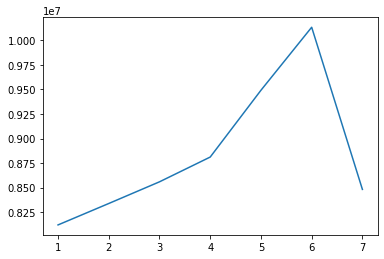

In [377]:
# sales per day of the week
week_day_stats = client.execute("""SELECT DAYOFWEEK(date), SUM(quantity) 
                            FROM test.sales WHERE date BETWEEN '2021-01-04' 
                            AND '2021-12-30' GROUP BY DAYOFWEEK(date)""")

plt.plot(*zip(*week_day_stats))
plt.show()

## space

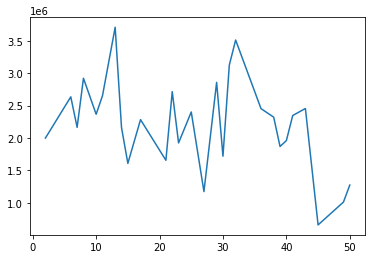

In [561]:
# warehouses probably differ by location
warehouse_stats = client.execute("""SELECT CAST(name AS INT), SUM(quantity) FROM 
                            test.sales JOIN test.warehouse ON 
                            test.sales.warehouse_id=test.warehouse.id WHERE 
                            date BETWEEN '2021-01-04' AND '2021-12-30' GROUP BY 
                            name ORDER BY name""")

plt.plot(*zip(*sorted(warehouse_stats, key=lambda x: x[0])))
plt.show()

## stocks

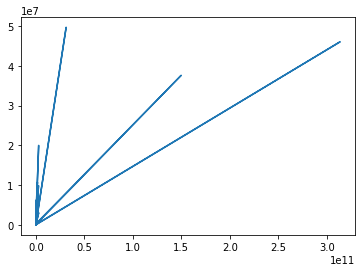

In [378]:
# dependence between sales and quantity in stocks
# hard to interpret but 
stock_stats = client.execute("""SELECT SUM(stocks_items.quantity), 
                            SUM(sales.quantity) FROM test.sales JOIN 
                            test.stocks_items ON 
                            test.sales.item_id=test.stocks_items.item_id 
                            GROUP BY item_id""")

plt.plot(*zip(*stock_stats))
plt.show()

# data preparation

In [562]:
# extract all necessary info for the final dataset
# drop the last 7 days for testing
res = client.execute("""SELECT date, CAST(name AS INT), quantity FROM test.sales 
                    JOIN test.warehouse ON
                    test.sales.warehouse_id=test.warehouse.id
                    WHERE item_id='7d185936-7a60-11eb-ba7f-4a6a34607ded' 
                    AND date BETWEEN '2021-01-11' AND '2021-12-30'""")

date = [x[0] for x in res]
month = [m[0].month for m in res]
month_day = [d[0].day for d in res]
week_day = [w[0].weekday() for w in res] 
warehouse = [y[1] for y in res]
quantity = [z[2] for z in res]

In [380]:
res2 = client.execute("""SELECT date, SUM(quantity) FROM test.stocks_on_days 
                    JOIN test.stocks_items 
                    ON test.stocks_on_days.item_id=test.stocks_items.item_id
                    WHERE item_id='7d185936-7a60-11eb-ba7f-4a6a34607ded' 
                    AND date BETWEEN '2021-01-11' AND '2021-12-30'
                    GROUP BY date ORDER BY date""")

stock_quantity = {x[0]:x[1] for x in res2}

In [381]:
# we actually should probably calculate avg for the past week for each 
# warehouse but since there is not enough info for each warehouse we'll just use 
# their average
# also, wanted to use mode but failed to come up with the right query
res3 = client.execute("""SELECT date, AVG(price), AVG(amount), AVG(sebes) 
                    FROM test.sales 
                    WHERE item_id='7d185936-7a60-11eb-ba7f-4a6a34607ded' 
                    GROUP BY date ORDER BY date""")

unique_date = [i[0] for i in res3]
price = [x[1] for x in res3]
amount = [y[2] for y in res3] 
sebes = [z[3] for z in res3]

In [382]:
# func to calculate avg for the past week
def average_past_week(seq):
    avgs = []

    for i in range(7,len(seq)):
        avg = round(sum(seq[i - 7:i]) / 7, 3)
        avgs.append(avg)

    return avgs

In [383]:
avg_price = average_past_week(price)
avg_amount = average_past_week(amount)
avg_sebes = average_past_week(sebes)

In [384]:
# func to match date dependant values with the set since it's repetitive
def match(seq, date=date):
    count = 0
    yield seq[count]
    for i in range(1,len(date)):
        if date[i] == date[i - 1]:
            yield seq[count]
        else:
            count += 1
            yield seq[count]

In [385]:
# the same func modified for stock quantity since it's a dict
def match_dates(seq, date=date):
    for i in range(len(date)):
        yield seq[date[i]]

# final dataframe, train/test devision


In [563]:
# create a dataframe to store extracted data
df = pd.DataFrame({'month': month,'month_day': month_day,'week_day': week_day,
                   'warehouse': warehouse})

df['stock_quantity'] = list(match_dates(stock_quantity))
df['stock_quantity'] = df['stock_quantity'].astype('int')
df['avg_price'] = list(match(avg_price))
df['avg_amount'] = list(match(avg_amount))
df['avg_sebes'] = list(match(avg_sebes))
df['quantity'] = quantity
df['quantity'] = df['quantity'].astype('int')
df = df.drop_duplicates()

In [564]:
df[:20]

,month,month_day,week_day,warehouse,stock_quantity,avg_price,avg_amount,avg_sebes,quantity
0,1,11,0,43,280,34.666,71.390,53.5,1
5,1,11,0,2,280,34.666,71.390,53.5,1
7,1,11,0,36,280,34.666,71.390,53.5,1
9,1,11,0,22,280,34.666,71.390,53.5,1
13,1,11,0,17,280,34.666,71.390,53.5,2
14,1,11,0,40,280,34.666,71.390,53.5,1
19,1,11,0,40,280,34.666,71.390,53.5,2
20,1,12,1,31,400,35.094,71.169,53.5,1
21,1,12,1,29,400,35.094,71.169,53.5,1
22,1,12,1,29,400,35.094,71.169,53.5,4


In [565]:
test_df = df.loc[(df.month == 12) & (df.month_day >= 23)].iloc[:,:-1]
test_df_target = df.loc[(df.month == 12) & (df.month_day >= 23)].iloc[:,-1]
test_df

      month  month_day  week_day  ...  avg_price  avg_amount  avg_sebes
7615     12         23         3  ...     67.924      77.069       62.0
7617     12         23         3  ...     67.924      77.069       62.0
7620     12         23         3  ...     67.924      77.069       62.0
7622     12         23         3  ...     67.924      77.069       62.0
7623     12         23         3  ...     67.924      77.069       62.0
7625     12         23         3  ...     67.924      77.069       62.0
7629     12         23         3  ...     67.924      77.069       62.0
7630     12         24         4  ...     67.530      74.361       62.0
7631     12         24         4  ...     67.530      74.361       62.0
7632     12         24         4  ...     67.530      74.361       62.0
7634     12         24         4  ...     67.530      74.361       62.0
7637     12         24         4  ...     67.530      74.361       62.0
7638     12         24         4  ...     67.530      74.361    

In [566]:
train_df = df.iloc[:-len(test_df), :-1]
train_df_target = df.iloc[:-len(test_df), -1]

# data normalization

In [551]:
# func for train normalization
# regression seems to need this
def normalize_frame(not_norm_df):
    values = not_norm_df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled = min_max_scaler.fit_transform(values)
    norm_df = pd.DataFrame(scaled, columns=not_norm_df.columns)
    return norm_df

In [572]:
norm_train_df = normalize_frame(train_df)
norm_train_df[:20]

,month,month_day,week_day,warehouse,stock_quantity,avg_price,avg_amount,avg_sebes
0,0.0,0.333333,0.000000,1.000000,0.000000,0.340555,0.337681,0.002294
1,0.0,0.333333,0.000000,0.000000,0.000000,0.340555,0.337681,0.002294
2,0.0,0.333333,0.000000,0.829268,0.000000,0.340555,0.337681,0.002294
3,0.0,0.333333,0.000000,0.487805,0.000000,0.340555,0.337681,0.002294
4,0.0,0.333333,0.000000,0.365854,0.000000,0.340555,0.337681,0.002294
5,0.0,0.333333,0.000000,0.926829,0.000000,0.340555,0.337681,0.002294
6,0.0,0.333333,0.000000,0.926829,0.000000,0.340555,0.337681,0.002294
7,0.0,0.366667,0.166667,0.707317,0.428571,0.349016,0.326551,0.002294
8,0.0,0.366667,0.166667,0.658537,0.428571,0.349016,0.326551,0.002294
9,0.0,0.366667,0.166667,0.658537,0.428571,0.349016,0.326551,0.002294


In [573]:
norm_test_df = normalize_frame(test_df)
norm_test_df

,month,month_day,week_day,warehouse,stock_quantity,avg_price,avg_amount,avg_sebes
0,0.0,0.000000,0.500000,0.533333,0.0,1.000000,0.438614,0.0
1,0.0,0.000000,0.500000,1.000000,0.0,1.000000,0.438614,0.0
2,0.0,0.000000,0.500000,0.566667,0.0,1.000000,0.438614,0.0
3,0.0,0.000000,0.500000,0.766667,0.0,1.000000,0.438614,0.0
4,0.0,0.000000,0.500000,0.633333,0.0,1.000000,0.438614,0.0
5,0.0,0.000000,0.500000,0.000000,0.0,1.000000,0.438614,0.0
6,0.0,0.000000,0.500000,0.900000,0.0,1.000000,0.438614,0.0
7,0.0,0.142857,0.666667,0.533333,0.0,0.832483,0.000000,0.0
8,0.0,0.142857,0.666667,0.566667,0.0,0.832483,0.000000,0.0
9,0.0,0.142857,0.666667,0.633333,0.0,0.832483,0.000000,0.0


# training and evaluation

In [575]:
# why?
# - good for small datasets
# - showed the best accuracy so far (+ naive_bayes)
# - typically used for sales predictions
model = LogisticRegression(max_iter=150)
model.fit(norm_train_df, train_df_target)
y_pred = model.predict(norm_test_df)

# why?
# need some kind of evaluation for further actions and conclusions
# not looking for anything serious, so for now accuracy will do, i guess
accuracy_score(test_df_target, y_pred)

0.775

# plotting

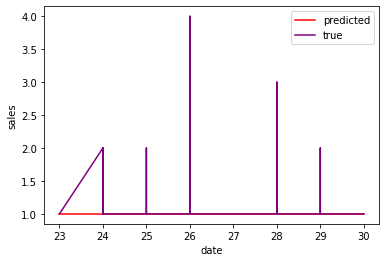

In [582]:
plt.plot(test_df.month_day, y_pred, color='red', label='predicted')
plt.plot(test_df.month_day, test_df_target, color='purple', label="true")
plt.xlabel("date")
plt.ylabel("sales")
leg = plt.legend()
plt.show()

# final answer

In [585]:
date_format = [f'{day}.12.2021' for day in test_df.month_day]
answer = pd.DataFrame({'date' : date_format, 'quantity': y_pred})
answer

,date,quantity
0,23.12.2021,1
1,23.12.2021,1
2,23.12.2021,1
3,23.12.2021,1
4,23.12.2021,1
5,23.12.2021,1
6,23.12.2021,1
7,24.12.2021,1
8,24.12.2021,1
9,24.12.2021,1


In [587]:
answer.to_csv('imprice_test_task.csv')

In [591]:
files.download('imprice_test_task.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# notes

In [361]:
# could theoretically consider brand
# but in our case only one brand makes our item
# probably could do better with stock and price if understood all the columns